In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import warnings
from scipy.optimize import minimize
from torch.utils.data import DataLoader

from src.model import SindyModel
from src.main import get_args
from src.dataloader import ScrewdrivingDataset

In [3]:
%matplotlib inline
plt.ioff()

In [4]:
ARGS = get_args()

model_dir = os.path.join('..', 'out', 'sindy-model-out', 'checkpoints')
processed_model_dir = os.path.join('..', 'out', 'sindy-out-processed')
singal_data_dir = os.path.join('..', 'out', 'sindy-data')
out_dir = os.path.join('..', 'out', 'final-plots')

os.makedirs(out_dir, exist_ok=True)

model_name = 'model_2024-05-11 15:00:41.789464.pth'
model_params_df = pd.read_csv(os.path.join(processed_model_dir, 'cumulative_results.csv'))
model_row = model_params_df[model_params_df.model_name == model_name].iloc[0]
segment_params_df = pd.read_csv(os.path.join(processed_model_dir, 'segmented', 'best_segmented_results.csv'))
segment_row = segment_params_df[segment_params_df.model_name == model_name].iloc[0]

segment_params = (segment_row.mean_adjustment, segment_row.time_shift)
full_x_params = (model_row.mean_adjustment_vx, model_row.time_shift_vx)
full_y_params = (model_row.mean_adjustment_vy, model_row.time_shift_vy)
ref_segment_start = segment_row.start_ref
target_segment_start = segment_row.start_target
segment_length = segment_row.segment_length

In [5]:
test_loader = DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))
test_x = torch.cat([batch[0] for batch in test_loader], dim=0)

test_y = [batch[1].numpy() for batch in DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))]
test_y = np.concatenate(test_y, axis=0)
test_y = test_y.reshape(test_y.shape[0], test_y.shape[-1])

In [6]:
def signal_error(params, reference_signals, target_signals):
    adjusted_signals = adjust_signal(target_signals, *params)
    return np.sum((reference_signals[0] - adjusted_signals[0]) ** 2) + np.sum((reference_signals[1] - adjusted_signals[1]) ** 2)

def adjust_signal(target_signals, mean_adjustment, time_shift):
    return [
        adjust_signal_single(target_signals[0], mean_adjustment, time_shift),
        adjust_signal_single(target_signals[1], mean_adjustment, time_shift),
    ]
    
def adjust_signal_single(target_signal, mean_adjustment, time_shift):
    shifted_target_signal = np.interp(np.arange(len(target_signal)), np.arange(len(target_signal)) - time_shift, target_signal)
    return shifted_target_signal + mean_adjustment

In [7]:
def plot_signals(pred_signals_vel, ref_signals_vel, pred_signals_dist, ref_signals_dist):
    t = np.arange(pred_signals_vel[0].shape[0]) / 30
    band_width = 0.001
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    
    axs[0].plot(t, ref_signals_vel[0], label='Measured Vx', color='orange')
    axs[1].plot(t, ref_signals_vel[1], label='Measured Vy', color='orange')
    axs[0].plot(t, pred_signals_vel[0], label='Predicted Vx', dashes=[6, 2])
    axs[1].plot(t, pred_signals_vel[1], label='Predicted Vy', dashes=[6, 2])
    
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Velocity Vx (m/s)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity Vy (m/s)')
    
    axs[0].legend()
    axs[0].grid(True)
    axs[1].legend()
    axs[1].grid(True)
    
    fig.suptitle('Velocity Prediction')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'velocity.png'))
    plt.show()
    plt.close()

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
       
    axs[0].fill_between(t, ref_signals_dist[0] - band_width, ref_signals_dist[0] + band_width, color='green', alpha=0.3)
    axs[0].plot(t, ref_signals_dist[0], label='Measured x', color='orange')
    
    axs[1].fill_between(t, ref_signals_dist[1] - band_width, ref_signals_dist[1] + band_width, color='green', alpha=0.3)
    axs[1].plot(t, ref_signals_dist[1], label='Measured y', color='orange')
    
    axs[0].plot(t, pred_signals_dist[0], label='Inferred x', dashes=[6, 2])
    axs[1].plot(t, pred_signals_dist[1], label='Inferred y', dashes=[6, 2])
    
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Distance x (m)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Distance y (m)')
    
    axs[0].legend()
    axs[0].grid(True)
    axs[1].legend()
    axs[1].grid(True)
    
    fig.suptitle('Distance Inference')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'distance.png'))
    plt.show()
    plt.close()

    fig, axs = plt.subplots(1, 1, figsize=(10, 6))

    axs.plot(ref_signals_dist[0], ref_signals_dist[1], label='Measured Path Trace', color='orange')
    axs.plot(pred_signals_dist[0], pred_signals_dist[1], label='Predicted Path Trace', dashes=[6, 2])
    
    axs.set_xlabel('Distance x (m)')
    axs.set_ylabel('Distance y (m)')
    
    axs.legend()
    axs.grid(True)
    
    fig.suptitle('Path Traced')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'trace.png'))
    plt.show()
    plt.close()

In [8]:
def gen_pos_from_vel(start_pos, vel_x, vel_y):
    positions = [start_pos]
    x, y = start_pos
    time_period = 1 / 30  # seconds
    
    for t in range(segment_length - 1):
        x += np.real(vel_x[t]) * time_period
        y += np.real(vel_y[t]) * time_period
        positions.append((x, y))

    positions = np.array(positions)
    
    return [positions[:, 0], positions[:, 1]]

/home/rutvik/Desktop/screwdriving-model-sindy-rcim/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rutvik/Desktop/screwdriving-model-sindy-rcim/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


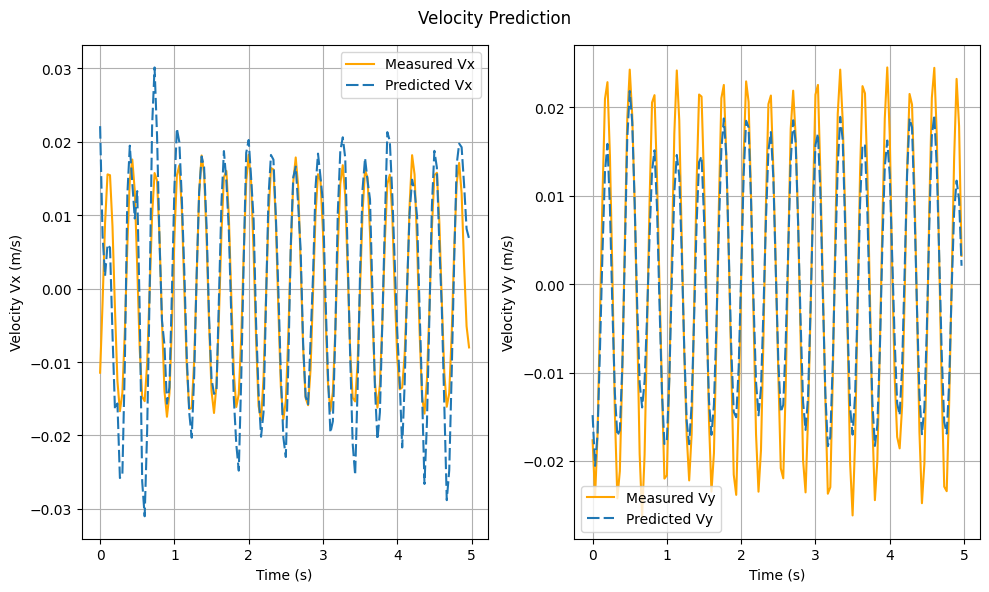

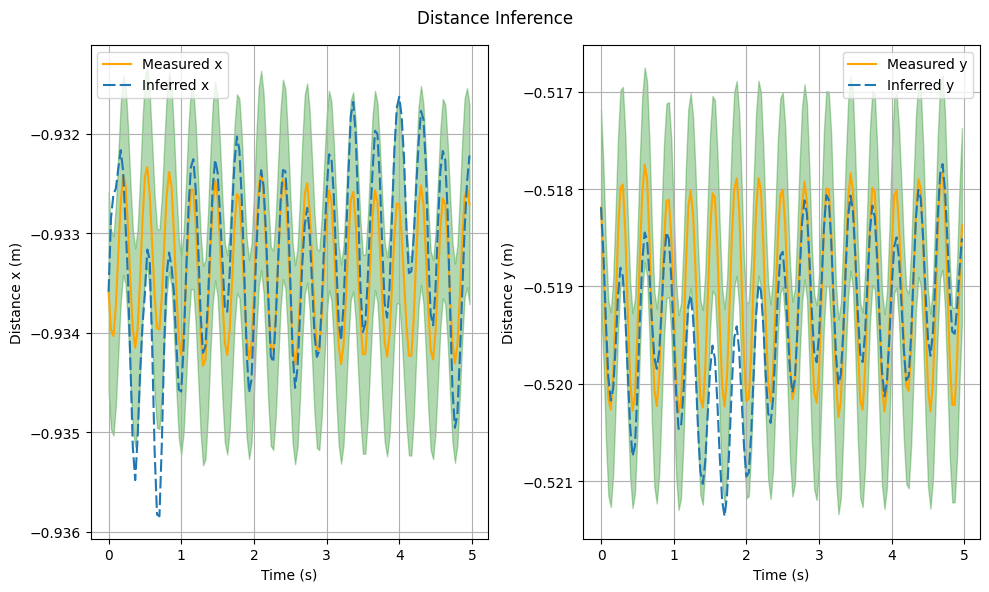

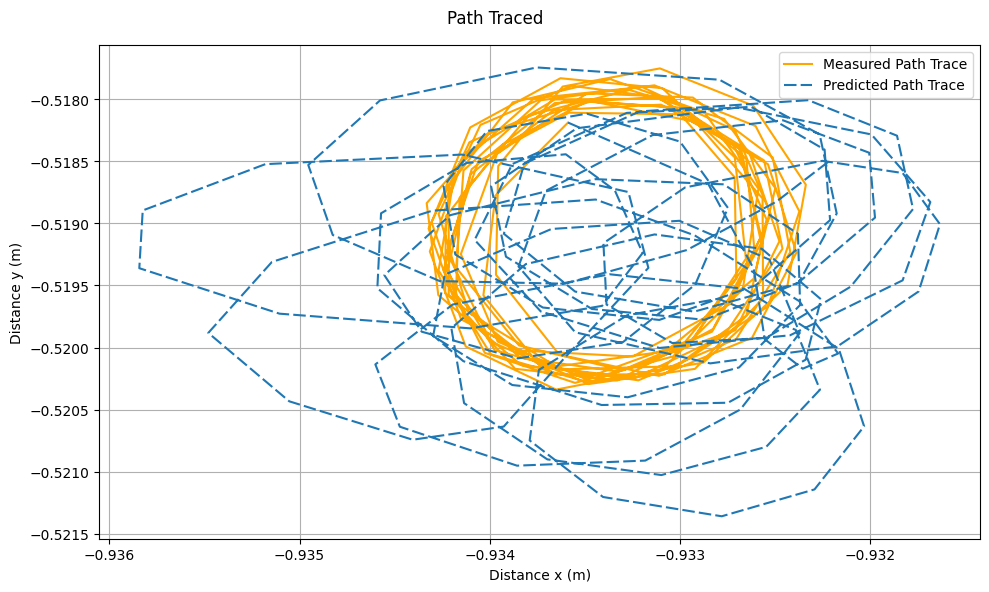

In [9]:
with torch.no_grad():
    model = SindyModel(**vars(ARGS))
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))
    model.eval()
    
    pred_y = model(test_x).numpy()
    pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[-1]).astype(np.complex64)
    
    reference_signal_x = np.copy(test_y)[:, 0]
    target_signal_x = pred_y[:, 0]
    adjusted_vx = adjust_signal_single(target_signal_x, *full_x_params)

    start_pos = test_x.numpy()[ref_segment_start, 0, :2].tolist()
    
    reference_signal_y = np.copy(test_y)[:, 1]
    target_signal_y = pred_y[:, 1]
    adjusted_vy = adjust_signal_single(target_signal_y, *full_y_params)
    
    best_segmented_vx, best_segmented_vy = adjust_signal([adjusted_vx, adjusted_vy], *segment_params)
    
    plot_signals(
        [
            best_segmented_vx[target_segment_start:target_segment_start + segment_length],
            best_segmented_vy[target_segment_start:target_segment_start + segment_length]
        ], 
        [
            reference_signal_x[ref_segment_start:ref_segment_start + segment_length], 
            reference_signal_y[ref_segment_start:ref_segment_start + segment_length]
        ],
        gen_pos_from_vel(
            start_pos,
            best_segmented_vx[target_segment_start:target_segment_start + segment_length],
            best_segmented_vy[target_segment_start:target_segment_start + segment_length]
        ),
        gen_pos_from_vel(
            start_pos,
            reference_signal_x[ref_segment_start:ref_segment_start + segment_length],
            reference_signal_y[ref_segment_start:ref_segment_start + segment_length]
        )
    )